# Dragon Raja: Examining Dragon Raja Treasure of Times Drop Rate (Part 1) 

<img src="https://encdn.ldmnq.com/ldstore/id/RwFZiN-1603965019896.jpg" width="800">

Dragon Raja is an MMORPG game developed by Archosaur Games. The game is well-known for its high quality graphic and its intense storyline. It also provide various classes for players to choose and various game modes. Apart from normal PvE and PvP gamemode, it also provides career, mini games and social relation functions. Despite these features, Dragon Raja also provide different fashion items for players to customize their own styles for their character and this feature earns Archosaur lots of income. 

Fashions used to be hard for players to obtain until developers introduced "Treasure of Time" package. Treasure of Time or 'ToT' is a lottery-liked items that reruns fashions from past events. The price for this item is lower and more accesible for a lot of players compared to outfit in other features.

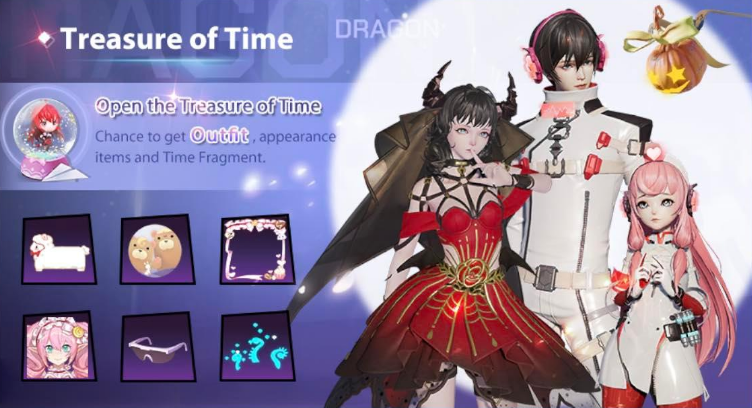

Treasure of Time resets every month. Each set of ToT introduced 2 sets of fashion from past events randomly. Each ToT box will have chance to give basic items, accessories. The biggest prize for this lottery is hair and outfit from 2 sets of the fashions. However, apart from discounted packages and 300 extra chance, players can only buy up to 99 boxes per day.

## Objective for Experiment
As I see myself, friends, clubmates and other players opened a lot of these lottery boxes. I came up with a lot of questions regards to the drop rates. Despite the fact, <b>the developers and the game do not reveal the actual rate to players.</b> But most of players says it tend to be around 1%, meaning you will likely to get 1 fashion item per 100 draws. To prove this, it's better to examine the rate and dive deep into it.

<b> I have 3 main questions to answer: </b>
1) What's the mean and distribution for overall fashions drop rate?

2) Does hair really have higher drop rate compared to outfit?

3) Do both set of fashions have identical drop rates?

## The Analysis

For the analysis, I will use the data I have been collecting from DRSEA players who opens Treasure of Times in each banner. The data is kept in an excel file and each entry is seperated by its banner. The data format has been set externally and it's almost ready for the analysis

Furthermore, to prevent writing same codes frequently, I have created a package named <code>treasure_mask</code> to help me with the analysis, you can check the details in the treasure_mask.py files

In [149]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from treasure_mask import *

For the experiment, I would use data from the first ToT banner, The Holy Hymph-Nebula Love banner. The data contains these following columns:

- <b>code</b>: represents what banner exist when Treasure of Time is drawn. This column was made for the sake of future analysis
- <b>set</b>: If fashion item is drawn, it will represent which fashion set the item come from. None if the result do not yield fashion items. 
- <b>part</b>: If fashion item is drawn, it will classify whether the item is hair or outfit. None if the result do not yield fashion items. 
- The N/A entries means the outcome is not fashion items that we interest in.

I think everyone wonders what is the hair and outfit for each outfit set looks like?  Here's a picture of it!  The fashion set on the left side is "Holy Hymph" while the right one is "Nebula Love". Both of them really look good. Expect for the Holy Hymph hair I guess.. Let's  not talk about it.

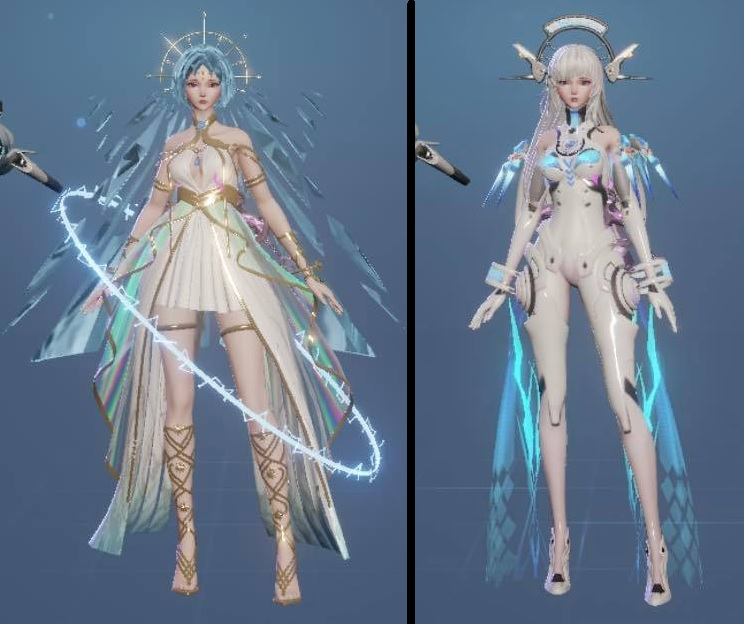

In [13]:
df = pd.read_excel("tot_simulation.xlsx",sheet_name='holy')

# Drop the code column as we only proceed on one banner only
df.drop(columns='code',inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5872 entries, 0 to 5871
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   set     65 non-null     object
 1   part    65 non-null     object
dtypes: object(2)
memory usage: 91.9+ KB


This tell us that out of 5872 draws attempt, only 65 draws come with at least a hair or clothes. Let's check out further more

In [23]:
# Calculate the observed drop rate
observed = df['set'].notnull().sum() * 100 / len(df) 
print('Observed Drop Rate: {:.4f}%'.format(observed))

Observed Drop Rate: 1.1069%


In [27]:
pd.crosstab(df['set'],df['part']).div(len(df)).mul(100)

part,hair,outfit
set,,
holy,0.408719,0.13624
nebula,0.340599,0.22139


From the table, we can see that the drop rate for each item varies. However, a deeper analysis is needed to confirm that these results do not come by random. For the analysis, we assume that the pooled result represents the population drop of items and we will perform bootstrap statistics on these samples.

For the test, we will bootstrap the mean drop rate for both aggregate and individual items using the tools from <code>treasure_mask</code> package! We will perform <b>10000 simulations with 100 draws for each simulation.</b> 100 draws is optimal number as 99 is the maximum amount of draws you can do daily excluded the extra chances.

In [70]:
# We going to need this in future
def mean_conf(array):
    mean = np.mean(array*100)
    [pct_025,pct_975] = np.percentile(array*100,[2.5,97.5]).tolist()
    print('Mean Drop Rate: {:.2f}%'.format(mean))
    print('Confidence Interval [{:.2f}%,{:.2f}%]'.format(pct_025,pct_975))

In [28]:
# Use the item encoder to label each draws into integers
df = ItemEncoder(df,"holy","nebula")
df.head()

,set,part,onehot
0,holy,outfit,1.0
1,holy,outfit,1.0
2,holy,outfit,1.0
3,holy,outfit,1.0
4,holy,outfit,1.0


In [29]:
# Performing bootstraps
agg_array = bootstrap_tot(df['onehot'].values,10000)

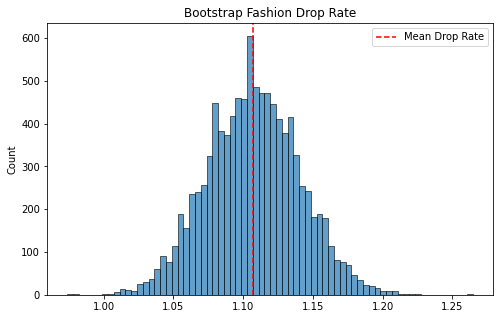

In [55]:
plt.figure(figsize=(8,5))
sns.histplot(agg_array*100,alpha=0.7)

plt.title('Bootstrap Fashion Drop Rate')
plt.axvline(np.mean(agg_array*100),color='red',linestyle='dashed')
plt.legend(['Mean Drop Rate'])

In [54]:
mean_conf(agg_array)

Mean Drop Rate: 1.11%
Confidence Interval [1.04%,1.17%]


From the results, 1% is not in the confidence interval. This means the aggregate fashion drop rate for this banner is significantly higher than 1% (but little bit higher than that) No wonder why players get 1 item per 100 draws while some are lucky getting more than 1 piece!

Now, the first question is answered, let's dive deep into hair and outfit rates.

In [56]:
# Bootstrapping hair and outfit rates
k = 10000
hair_array, cloth_array = np.empty(k), np.empty(k)

# Using loops instead of bootstrap function to ensure that both arrays come from same draws
for i in range(k):
    temp_array = draw_tot(df['onehot'].values)
    hair_array[i] = hair_mask(temp_array,result=2)
    cloth_array[i] = outfit_mask(temp_array,result=2)

Text(0.5, 1.0, 'Hair vs Outfit Distribution')

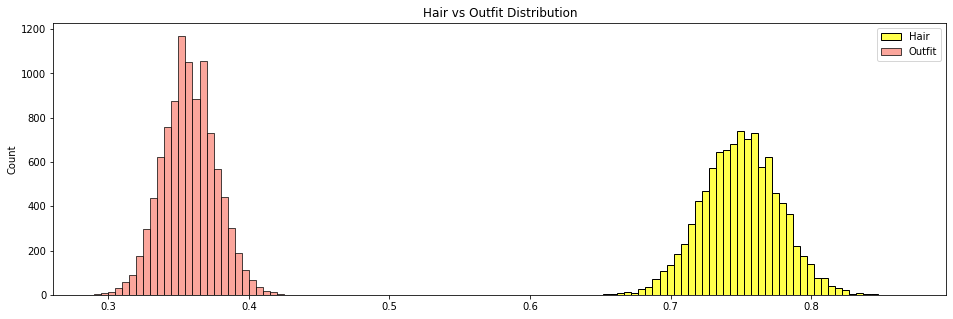

In [65]:
plt.figure(figsize=(16,5))
sns.histplot(hair_array*100,alpha=0.7,color='yellow',binwidth=0.005)
sns.histplot(cloth_array*100,alpha=0.7,color='salmon',binwidth=0.005)
plt.legend(['Hair','Outfit'])
plt.title('Hair vs Outfit Distribution')

In [71]:
mean_conf(hair_array/cloth_array)

Mean Drop Rate: 210.12%
Confidence Interval [184.66%,238.63%]


Juding from visually, we can see that outfit and hair have different distributions with hair rate far more superior than outfit ones. Calculating the ratio, <b>hair rate doubles the outfit rate.</b> This means if you draw 3 fashion items, it's likely to be 2 hairs and 1 outfit.

Now, awaiting last question: Does both set of fashion have identical drop rate? let's tackle the question using same approach.

In [78]:
# Bootstrapping each fashion set rates
k = 10000
holy_array, nebula_array = np.empty(k), np.empty(k)

# Using loops instead of bootstrap function to ensure that both arrays come from same draws
for i in range(k):
    temp_array = draw_tot(df['onehot'].values)
    holy_array[i] = multi_mask(temp_array,result=2,target=[1,2])
    nebula_array[i] = multi_mask(temp_array,result=2,target=[3,4])

Text(0.5, 1.0, 'Set vs Set Distribution')

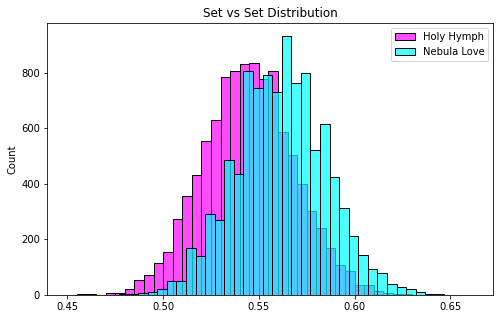

In [81]:
plt.figure(figsize=(8,5))
sns.histplot(holy_array*100,alpha=0.7,color='magenta',binwidth=0.005)
sns.histplot(nebula_array*100,alpha=0.7,color='cyan',binwidth=0.005)
plt.legend(['Holy Hymph','Nebula Love'])
plt.title('Set vs Set Distribution')

It seems that the droprates from both sets have some overlapping parts. Let's test something more.

In [106]:
# Calculate empirical difference
set1 = df['set'].value_counts()['holy'] 
set2 = df['set'].value_counts()['nebula'] 

empirical_diff = np.abs(set2 - set1) / len(df) 
empirical_diff *= 100

# Calculate bootstrap mean diff
diff_array = np.abs(nebula_array - holy_array) * 100

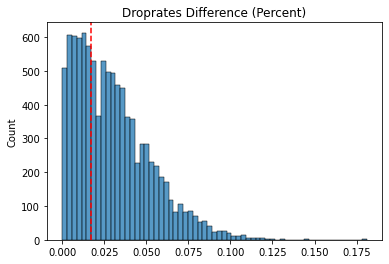

In [108]:
sns.histplot(diff_array)
plt.title('Droprates Difference (Percent)')

plt.axvline(empirical_diff,color='red',linestyle='dashed')

In [111]:
pval = np.sum(diff_array >= empirical_diff) / len(diff_array)
print('p-value:',pval)

p-value: 0.6496


From the result, it seems that we do not have enough evidence to reject that both sets have different rate. However, do remind that each fashion set has two items: hair and outfit. It's possible that their hair and outfit rates are diffrent but aggregate rate sum up to nearly same value. Let's dive deeper into individual item rate

In [152]:
# Bootstrapping item rates
k = 10000
items = [holy_outfit, holy_hair, nebula_outfit, nebula_hair] = [np.empty(k) for i in range(4)]


# Using loops instead of bootstrap function to ensure that both arrays come from same draws
for i in range(k):
    temp_array = draw_tot(df['onehot'].values)
    holy_outfit[i] = individual_mask(temp_array,result=2,target=1)
    holy_hair[i] = individual_mask(temp_array,result=2,target=2)
    nebula_outfit[i] = individual_mask(temp_array,result=2,target=3)
    nebula_hair[i] = individual_mask(temp_array,result=2,target=4)

Text(0.5, 1.0, 'Holy Hymph vs Nebula Love (Hair)')

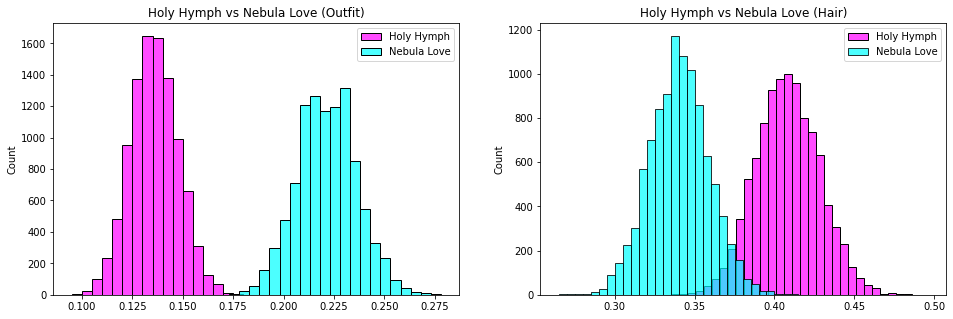

In [153]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

sns.histplot(holy_outfit*100,alpha=0.7,color='magenta',binwidth=0.005,ax=ax[0])
sns.histplot(nebula_outfit*100,alpha=0.7,color='cyan',binwidth=0.005,ax=ax[0])
ax[0].legend(['Holy Hymph','Nebula Love'])
ax[0].set_title('Holy Hymph vs Nebula Love (Outfit)')

sns.histplot(holy_hair*100,alpha=0.7,color='magenta',binwidth=0.005,ax=ax[1])
sns.histplot(nebula_hair*100,alpha=0.7,color='cyan',binwidth=0.005,ax=ax[1])
ax[1].legend(['Holy Hymph','Nebula Love'])
ax[1].set_title('Holy Hymph vs Nebula Love (Hair)')

The results prove our guess, each set has different hair:outfit ratio but by summing all up, they seem to have similar total drop rates. This matches my experience during my time in that banner (which I haven't with this project yet): Holy Hymph Hair and Nebula Love Outfit comes more frequent than its another set counterpart.

But, what's the individual item drop rate?, you may ask. This is the results:

In [155]:
columns = {'Set': ['Holy Hymph', 'Nebula Love'], 'Part': ['Outfit', 'Hair'],}
rates = []

order = columns.keys()
sum_df = pd.DataFrame(itertools.product(*[columns[k] for k in order]), columns=order)

for arr in items:
    rates.append(np.mean(arr)*100) 

In [158]:
sum_df['DropRate (%)'] = rates
sum_df.round(4)

,Set,Part,DropRate (%)
0,Holy Hymph,Outfit,0.1363
1,Holy Hymph,Hair,0.4086
2,Nebula Love,Outfit,0.2216
3,Nebula Love,Hair,0.3406


## Conclusion

From the analysis, we found that:

1. We reject community's hypothesis that total droprate is 1%. The droprate seems to be higher that that.
2. Hair droprate is higher than Outfit droprate.
3. Both set of fashion has same drop rate but different hair/outfit ratio. 

Despite that, I still have questions whether these conclusions will hold in future Treasure of Times. Players in the community feels that the droprate is worsen in later Treasure of Times. I have the data to examine these but the content will be too long for now.

In the next part we will answer one main question: <b>Are all Treasure of Times banner identical? or EVA has secretly change the rate or proportion as time passes?</b> Let's find the answer in next part. For now, Goodbye!

But let's have a glimpse of my character in Holy Hymph before you guys go :3

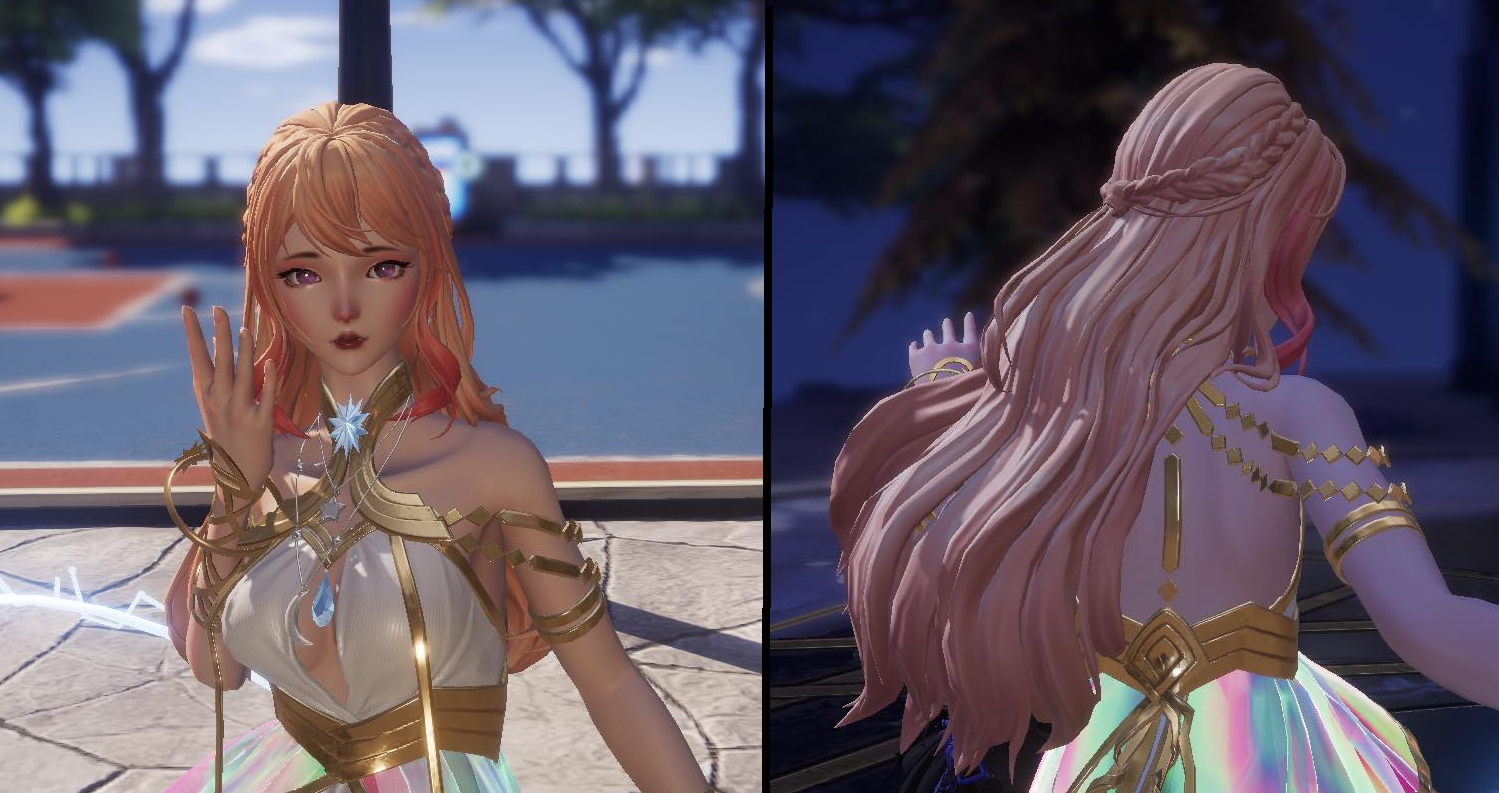